**Professor:** Enrique Garcia Ceja
**email:** enrique.gc@tec.mx

# Exercise: Activity recognition with a CNN and transfer learning.

In this exercise you will train a CNN to classify human acitivities from accelerometer sensors collected with a smartphone. You will be using the human activity recognition WISDM dataset (http://www.cis.fordham.edu/wisdm/dataset.php) which contains 6 different activities: walking, jogging, walking upstairs, walking downstairs, sitting and standing. The data was collected with an Android phone located in the participants' pants pocket. You will also use transfer learning to fine tune your model and adapt it to a specific user.

The data was collected with a sampling rate of 20Hz (1 sample every 50ms). The accelerometer sensor captures values from three orientations (x,y and z). The picture below shows an example of acceleration values over time while a participant was walking.

<table><tr><td><img src="https://github.com/enriquegit/ap-img/blob/main/img/cel.png?raw=true" width="200"></td><td><img src="https://github.com/enriquegit/ap-img/blob/main/img/walking.png?raw=true" width="400"></td></tr></table>

From the picture above, it can be seen that we are dealing with time series data. But how can we train a CNN with this type of data? You can transform your data into an image-like representation! The timeseries data can be shaped into a matrix-like structure. See image below. In the example, the timeseires have a length of 9 and they are reshaped into 3x3 matrices. This can be seen as a RGB image (red, green, blue) but in this case it is a XYZ image! The time series values will be treated as if they were image pixels.

<img src="https://github.com/enriquegit/ap-img/blob/main/img/representation.png?raw=true" width="750">

The dataset has already been converted into image-like representations. The timeseries were split into five seconds segments (non-overlapping). Since the sampling rate was 20Hz, we will have arrays of length 100 for each x, y and z. The arrays will be reshaped into 10x10 images. Since we have x, y and z, each instance will be an image with dimension 10x10x3. Each row in the file images.txt contains the five second segments for all x, y and z values flattened. That is, the first 100 values correspond to x, the next 100 values to y and the last 100 values to z. The last two columns are the userid and label, respcectively.

**In this exercise you will:**

* Select a target user and build a model for her/him.
* Train a general (user independent) CNN model.
* Use 50% of the target user data as test set. Use the remaining 50% to build an adaptive model by fine tuning the general model using transfer learning.


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras import Model

from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [80]:
# Path to the dataset.
filepath = "/content/images.txt"

# We will save the trained CNN model into a file. Specify the path where the model will be saved.
savemodelpath = "/content/" # Make sure the directory already exists in your local computer.

# Define the size of the images.
img_width = 10
img_height = 10
img_depth = 3

# Read the dataset.
dataset = pd.read_csv(filepath)

In [81]:
# Display the first 5 rows of the dataset.
dataset.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v293,v294,v295,v296,v297,v298,v299,v300,userid,label
0,-0.694638,5.012288,4.903325,-0.612916,-1.184970,1.375655,-0.612916,-0.503953,-8.430995,0.953424,...,4.208687,-4.331271,11.563675,7.736358,3.677494,0.994285,-1.566340,6.742072,33,Jogging
1,2.111154,4.208687,-5.134871,3.023717,2.070293,-3.105439,-4.399372,4.753501,-0.694638,-2.833032,...,-8.349273,9.575105,2.220117,4.481094,0.081722,-5.856750,7.123442,-9.112013,33,Jogging
2,-5.012288,1.920469,2.792171,-0.953424,-10.079058,4.372132,-1.307553,0.381370,3.105439,2.451662,...,-0.272407,15.404613,-3.786457,4.018002,2.301839,3.377846,3.909040,3.786457,33,Jogging
3,11.073342,-3.868179,7.055340,-8.730643,3.064578,-1.607201,4.208687,-2.601486,4.440233,2.369940,...,5.747787,3.064578,-0.149824,6.851035,-12.830367,-5.666065,3.949901,2.982856,33,Jogging
4,6.278980,-2.138395,-2.533385,0.572055,-7.654635,5.747787,-10.038197,0.313268,-7.627395,-1.566340,...,4.399372,-1.334794,5.666065,-3.595772,15.663400,-3.949901,6.401564,3.636633,33,Jogging


In [82]:
# Select features 'pixels' (acceleration values), userids,and class.
pixels = dataset.drop(['userid','label'], axis=1)
userids = dataset[['userid']]
labels = dataset[['label']]

# Convert to numpy.
pixels = pixels.values
userids = userids.values
labels = labels.values

# Encode the labels from strings to integers.
le = LabelEncoder()

labels = le.fit_transform(labels.ravel())

# Reshape pixels into images of 10x10x3.
images = np.reshape(pixels, (pixels.shape[0],img_width,img_height,img_depth), order='F')

Now the `images` variable contains all our 10x10x3 images. The `userids` and `labels` variables contain the user ids and activity labels, respectively.

In [83]:
# Print the shapes of our data.
print(userids.shape)
print(labels.shape)
print(images.shape)

(6647, 1)
(6647,)
(6647, 10, 10, 3)


In [84]:
# Shuffle the data.

def shuffle_instances(features, userids, labels):
    n = features.shape[0]
    np.random.seed(1234)
    idxs = np.random.choice(n, size=n, replace=False)
    features = features[idxs,:,:,:]
    userids = userids[idxs]
    labels = labels[idxs]

    return(features, userids, labels)

images, userids, labels = shuffle_instances(images, userids, labels)

Let's plot some of the images! The following code will print some warnings since the images are not exactly between 0-255 because strictly speaking, they are not images but the visualizations will still be useful. We can see that for low energy activities such as sitting or standing, the colors look very solid. On the other hand, for the jogging activity, the images look more fragmented.

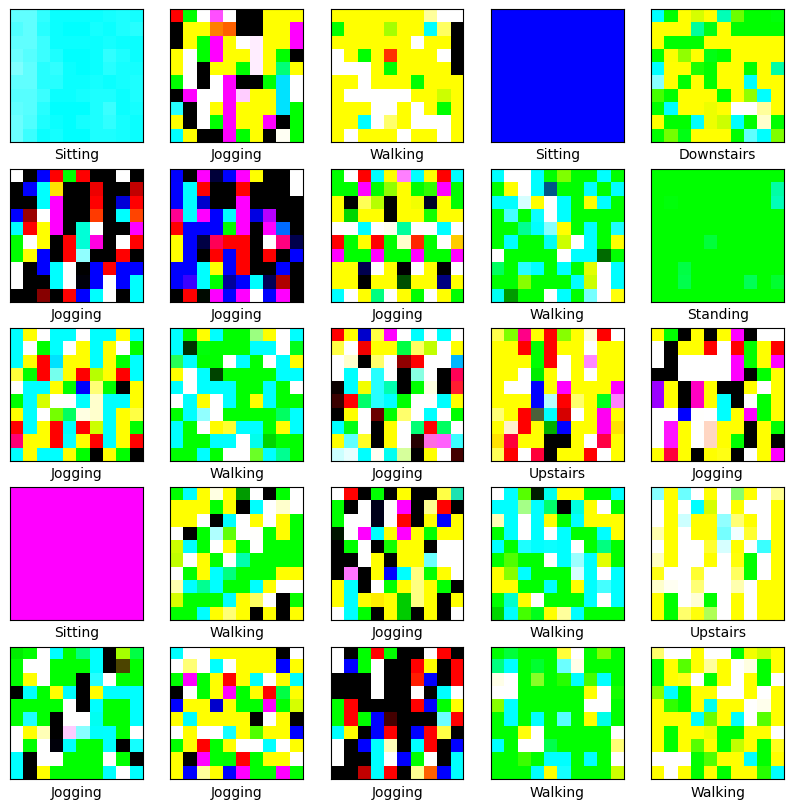

In [85]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(le.inverse_transform(labels)[i])
plt.show()

In [86]:
# Print the available user ids.
with np.printoptions(threshold=np.inf):
    print(np.unique(userids))

[ 3  5  6  7  8 12 13 18 19 20 21 24 27 29 31 32 33 34 36]


In [87]:
# Select a target user from the above ids. This is the user we will use to test the general model.
# We will also adapt the general model to this target user.

target_user =  13

In [88]:
# Split into training test sets.
# The train set will be the data from all users except target_user.
# The train set will be stored in images_all and labels_all.
# The test set will be the data that belongs to target_user and is stored in images_target and labels_target.

# Get indices
idxs_target = np.where(userids == target_user)[0]
idxs_all = np.where(userids != target_user)[0]

images_all = images[idxs_all]
labels_all = labels[idxs_all]

images_target = images[idxs_target]
labels_target = labels[idxs_target]

In [89]:
# Normalize images using the maximum value from the training data (images_all).

# First, get the maximum value from images_all.
# The max() function from numpy returns the maximum value of a numpy array.
maxval =  images_all.max()

# Normalize images_all using maxval.
images_all =  images_all/maxval

# Normalize images_target using maxval.
images_target =  images_target/maxval

Now we need a train and test set for the target user. The training set is used to fine tune the general model. We will use 50% of the target user's data to adapt the general model and the remaining to test the performance.

Randomly split the target_user data (`images_target` `labels_target`) and assign 50% of the images and labels into variables defined as `images_target_train` and `labels_target_train` respectively. Store the remaining 50% of the images and labels in `images_target_test` and `labels_target_test`. Tip: You can use the `train_test_split()` function from scikit learn.

In [90]:
images_target_train, images_target_test, labels_target_train, labels_target_test = train_test_split(images_target, labels_target, test_size=0.5, random_state=1234)


In [91]:
# Print the dimensions of our datasets.
print(images_target_train.shape)
print(labels_target_train.shape)

print(images_target_test.shape)
print(labels_target_test.shape)

(181, 10, 10, 3)
(181,)
(181, 10, 10, 3)
(181,)


Now build a CNN model. Since the images are small, you are advised to use a small kernel size, e.g., (2,2). Remember that you can use dropout to reduce overfitting.

In [92]:
# Define your CNN general model here using keras functional API and name it 'model'.
# The model takes as input images and predicts the activity type.
# You should assign a unique name to each layer with the 'name' attribute.
# This will later allow you to select specific layers by name.

# Input layer
input_layer = Input(shape=(img_width,img_height,img_depth), name="input_layer")

# First convolutional layer with small kernel and ReLU activation
x = Conv2D(filters=16, kernel_size=(2, 2), activation="relu", name="conv_layer_1")(input_layer)
x = MaxPooling2D(pool_size=(2, 2), name="maxpool_1")(x)

# Second convolutional layer
x = Conv2D(filters=32, kernel_size=(2, 2), activation="relu", name="conv_layer_2")(x)
x = MaxPooling2D(pool_size=(2, 2), name="maxpool_2")(x)

# Flatten the feature maps to feed into the Dense layer
x = Flatten(name="flatten")(x)

# Fully connected (Dense) layer with dropout
x = Dense(units=128, activation="relu", name="dense_1")(x)
x = Dropout(rate=0.5, name="dropout_1")(x)

# Output layer with softmax activation (assuming multi-class classification)
output_layer = Dense(units=6, activation="softmax", name="output_layer")(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer, name="cnn_activity_model")

In [93]:
# Print a summary of your model.
model.summary()

Model: "cnn_activity_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 10, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_1 (Conv2D)                │ (None, 9, 9, 16)            │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling2D)             │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_2 (Conv2D)                │ (None, 3, 3, 32)            │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling2D)             │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,286 (28.46 KB)

 Trainable params: 7,286 (28.46 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# Define an optimizer and its learning rate.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Set the batch size.
batch_size = 32

# Set the number of epochs.
num_epochs = 20

# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Fit the general model with data from all users except the target user (images_all, labels_all).
history = model.fit(images_all, labels_all,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_split=0.15,
                    verbose=1)

# Save model after it has been fitted.
model.save(savemodelpath + 'my_model.keras')


Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4935 - loss: 1.3410 - val_accuracy: 0.6988 - val_loss: 0.8054
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7479 - loss: 0.7169 - val_accuracy: 0.7741 - val_loss: 0.6075
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7985 - loss: 0.5808 - val_accuracy: 0.7837 - val_loss: 0.5093
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8124 - loss: 0.5064 - val_accuracy: 0.7932 - val_loss: 0.4669
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8269 - loss: 0.4668 - val_accuracy: 0.8293 - val_loss: 0.4020
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8470 - loss: 0.4042 - val_accuracy: 0.8452 - val_loss: 0.3691
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8558 - loss: 0.3730 - val_accuracy: 0.8568 - val_loss: 0.3408
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8580 - loss: 0.3723 - val_accuracy: 0.

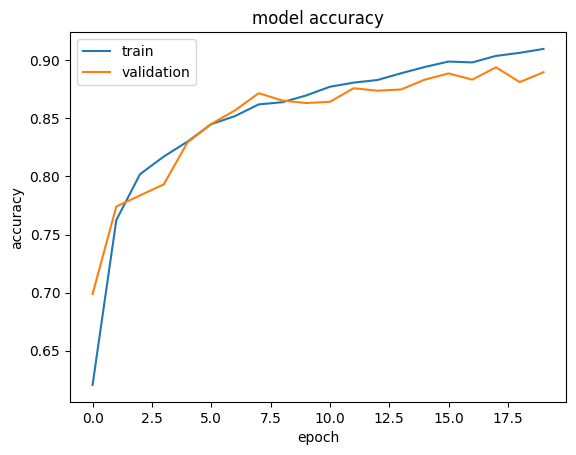

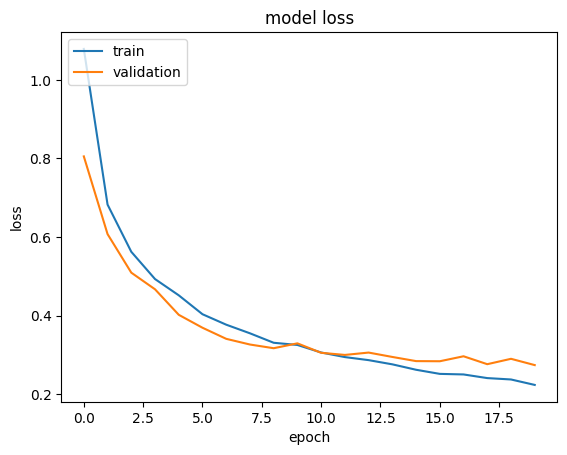

In [95]:
# plot history

import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [96]:
# Evaluate the model on the target user's test data and print accuracy.
# You can use the model.evaluate() function.
test_loss, test_accuracy = model.evaluate(images_target_test, labels_target_test)
print(f"Test Accuracy on target user's data: {test_accuracy:.2f}")




6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9155 - loss: 0.2177 
Test Accuracy on target user's data: 0.92


### Apply transfer learning

Now, let's load the general model and adapt it to the target user.

In [97]:
# Load the general model previously trained.
model = keras.models.load_model(savemodelpath + 'my_model.keras')
model.summary()

Model: "cnn_activity_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 10, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_1 (Conv2D)                │ (None, 9, 9, 16)            │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling2D)             │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_2 (Conv2D)                │ (None, 3, 3, 32)            │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling2D)             │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,860 (85.39 KB)

 Trainable params: 7,286 (28.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,574 (56.93 KB)

In [98]:
# Freeze some of the layers of the genral model to apply transfer learning.
# Each layer has a 'trainable' attribute that you can set to False.
# When you re-fit a model, layers whose trainable attribute is False will be untouched.
# You can retrieve a layer with model.get_layer("layerName")

model.get_layer("conv_layer_1").trainable = False
model.get_layer("conv_layer_2").trainable = False


# Define an optimizer and its learning rate.
optimizer2 = keras.optimizers.Adam(learning_rate=0.001)

# Compile the model again to apply changes.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer2,
              metrics=['accuracy'])


In [99]:
# Print summary.
model.summary()

Model: "cnn_activity_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 10, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_1 (Conv2D)                │ (None, 9, 9, 16)            │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling2D)             │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_2 (Conv2D)                │ (None, 3, 3, 32)            │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling2D)             │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,286 (28.46 KB)

 Trainable params: 4,998 (19.52 KB)

 Non-trainable params: 2,288 (8.94 KB)

After freezing some layers you can note that the number of trainable parameters was reduced. Now let's fine tune the model with the target user's train set: `images_target_train` `labels_target_train`.

In [100]:
#### COMPLETE THE CODE ####
# Since the target train set is very small, you can set validation_split = 0.0

history = model.fit(images_target_train, labels_target_train,
                    batch_size = batch_size,
                    epochs = 15,
                    validation_split = 0.0,
                    verbose = 1)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9148 - loss: 0.1682
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9476 - loss: 0.1568 
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9229 - loss: 0.1622 
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8960 - loss: 0.2172 
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9392 - loss: 0.1572 
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9281 - loss: 0.1785 
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9276 - loss: 0.1576 
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8968 - loss: 0.1843  
Epoch 9/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9197 - loss: 0.1750 
Epoch 10/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9207 - loss: 0.1932 
Epoch 11/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9323 - loss: 0.1613 
Epoch 12/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9500 - loss: 0.1399 
E

In [101]:
# Evaluate the adapted model on the test set (images_target_test) and print accuracy.

test_loss, test_acc = model.evaluate(images_target_test, labels_target_test)
print('Test accuracy:', test_acc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9344 - loss: 0.2004  
Test accuracy: 0.9447513818740845


After fine tunning your model the accuracy should be higher now!

**This is the end of the exercise.**

In [102]:
!jupyter nbconvert --execute --to html "/content/activity_2_activities_cnn_1.ipynb"

[NbConvertApp] Converting notebook /content/activity_2_activities_cnn_1.ipynb to html
2024-11-13 22:36:46.150930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 22:36:46.221280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 22:36:46.243247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 22:36:49.008835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 651058 bytes to /content/activity_2_activities_cnn_1.html
